# Assignment 3: Fine tuning a multiclass classification BERT model

**Description:** This assignment covers fine-tuning of a multiclass classification. You will compare two different types of solutions using BERT-based models. You should also be able to develop an intuition for:


* Working with BERT
* The effects of using different model checkpoints and fine-tuning some hyperparameters
* Different metrics to measure the effectiveness of your model
* The effect of partially cleaning/normalizing your training data



The assignment notebook closely follows the lesson notebooks. We will use the 20 newsgroups dataset and will leverage some of the models, or part of the code, for our current investigation. 

**You are strongly encouraged to read through the entire notebook before answering any questions or writing any code.**

The initial part of the notebook is purely setup. We will then generate our BERT model and see if and how we can improve it. 

Do not try to run this entire notebook on your GCP instance as the training of models requires a GPU to work in a timely fashion. This notebook should be run on a Google Colab leveraging a GPU. By default, when you open the notebook in Colab it will try to use a GPU. Total runtime of the entire notebook (with solutions and a Colab GPU) should be about 1h.


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/datasci-w266/2022-summer-main/blob/master/assignment/a3/Multiclass_text_classification.ipynb)

The overall assignment structure is as follows:

1. Setup
  
  1.1 Libraries & Helper Functions

  1.2 Data Acquisition

  1.3 Training/Test/Validation Sets for BERT-based models

2. Classification with a fine tuned BERT model

  2.1 Create the specified BERT model
  
  2.2 Fine tune the BERT model as directed

  2.3 Examine the predictions with various metrics

3. Classification with some preprocessed data and the BERT model

  3.1 Clean up the data a bit

  3.2 Regenerate the data with the appropriate tokenizer

  3.3 Regenerate the BERT model

  3.4. Rerun the data and examine the predictions

4. Try again with a different mini batch size to see if that improves performance  



**INSTRUCTIONS:**: 

* Questions are always indicated as **QUESTION:**, so you can search for this string to make sure you answered all of the questions. You are expected to fill out, run, and submit this notebook, as well as to answer the questions in the **answers** file as you did in a1 and a2.

* **### YOUR CODE HERE** indicates that you are supposed to write code.

* If you want to, you can run all of the cells in section 1 in bulk. This is setup work and no questions are in there. At the end of section 1 we will state all of the relevant variables that were defined and created in section 1.


### 1. Setup

Lets get all our libraries and download and process our data.

In [ ]:
!pip install -q transformers

     |████████████████████████████████| 4.4 MB 5.1 MB/s 
     |████████████████████████████████| 6.6 MB 39.7 MB/s 
     |████████████████████████████████| 596 kB 44.1 MB/s 
     |████████████████████████████████| 101 kB 4.7 MB/s 


In [ ]:
!pip install pydot --quiet

In [ ]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
from collections import Counter
import numpy as np
import tensorflow as tf
from tensorflow import keras

import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint 

In [ ]:
from transformers import BertTokenizer, TFBertModel

In [ ]:
# 4-window plot. Small modification from matplotlib examples.

def make_plot(axs, history1, 
              history2, 
              y_lim_loss_lower=0.4, 
              y_lim_loss_upper=1.6,
              y_lim_accuracy_lower=0.4, 
              y_lim_accuracy_upper=0.9,
              model_1_name='model 1',
              model_2_name='model 2',
              
             ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    ax1 = axs[0, 0]
    ax1.plot(history1.history['loss'])
    ax1.plot(history1.history['val_loss'])
    ax1.set_title('loss - ' + model_1_name)
    ax1.set_ylabel('loss', bbox=box)
    ax1.set_ylim(y_lim_loss_lower, y_lim_loss_upper)

    ax3 = axs[1, 0]
    ax3.set_title('accuracy - ' + model_1_name)
    ax3.plot(history1.history['accuracy'])
    ax3.plot(history1.history['val_accuracy'])
    ax3.set_ylabel('accuracy', bbox=box)
    ax3.set_ylim(y_lim_accuracy_lower, y_lim_accuracy_upper)


    ax2 = axs[0, 1]
    ax2.set_title('loss - ' + model_2_name)
    ax2.plot(history2.history['loss'])
    ax2.plot(history2.history['val_loss'])
    ax2.set_ylim(y_lim_loss_lower, y_lim_loss_upper)

    ax4 = axs[1, 1]
    ax4.set_title('accuracy - ' + model_2_name)
    ax4.plot(history2.history['accuracy'])
    ax4.plot(history2.history['val_accuracy'])
    ax4.set_ylim(y_lim_accuracy_lower, y_lim_accuracy_upper)

In [ ]:
def read_20newsgroups(test_size=0.1):
  # download & load 20newsgroups dataset from sklearn's repos
  dataset = fetch_20newsgroups(subset="all", shuffle=True, remove=("headers", "footers", "quotes"))
  documents = dataset.data
  labels = dataset.target
  # split into training & testing a return data as well as label names
  return train_test_split(documents, labels, test_size=test_size), dataset.target_names
  
# call the function
(train_texts, test_texts, train_labels, test_labels), target_names = read_20newsgroups()

Take a look at the records.  We basically have a long string of text and an associated label.  That label is the Usenet group where the posting occured. The records are the raw text.  They vary significantly in size.

In [ ]:
train_texts[:2]

[": Detroit's going to beat Toronto in 6 or LESS!!!\n: \n:  Granted, Gilmour should get the Hart Trophy, NOT Lemieux... Just\n: Look at what Gilmour did for Toronto.  When you think of Toronto,\n: who comes to mind, Gilmour, Andreychuk, Potvin...ah...did I mentio\n: n Gilmour?\n: \n\nWhen you think of the NHL, who comes to mind? Gilmour? Gretzky? Mario?\n.. ah... did I mention Mario? If you said Gretzky, you haven't really\nbeen following along, have you. If you said Gilmour, you are a true\nMaynard. \n\nI don't even think the selection of the HArt deserves serious discussion on\nthis group. It is a no-brainer.",
 'For Sale:\n\nFujitsu 324meg SCSI drive.  $450\n\nMaxtor 338meg ESDI drive.  $425\n\nMaxtor 160meg ESDI drive.  $225\n\nToshiba 106meg IDE drive.  $175\n\nXT case & motherboard.  $50\n\nDTC 16-bit MFM 2HD 2FD controler.  $30\n\nAll items are used, in full working condition, and have a  \nwarranty for one week unless otherwise specified.  All prices \nare %100 negotiable, ship

Notice the "labels" are just integers that are an offset into the list of target names.

In [ ]:
train_labels[:2]

array([10,  6])

The variable ''target_names'' stores all of the names of the labels.

In [ ]:
print(target_names)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


We already have a test set and a train set.  Let's explicitly set aside part of our training set for validation purposes.

In [ ]:
len(train_texts)
valid_texts = train_texts[16000:]
valid_labels = train_labels[16000:]
train_texts = train_texts[:16000]
train_labels = train_labels[:16000]

The validation set will always have 961 records.

In [ ]:
len(valid_texts)

961

The training set will always have 16000 records.

In [ ]:
len(train_texts)

16000

In [ ]:
#get the labels in a needed data format for validation
npvalid_labels = np.asarray(valid_labels)

* train_texts - an array of text strings for training
* test_texts - an array of text strings for testing 
* valid texts - an array of text strings for validation
* train_labels - an array of integers representing the labels associated with train_texts
* test_labels - an array of integers representing the labels associated with test_texts
* valid_labels - an array of integers representing the labels associated with valid_texts
* target_names - an array of label strings that correspond to the integers in the *_labels arrays

### 2. Classification with a fine tuned BERT model

Let's pick our BERT model.  We'll start with the base BERT model and we'll use the cased version since our data has capital and lower case letters.

In [ ]:
#make it easier to use a variety of BERT subword models
model_checkpoint = 'bert-base-cased'

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
bert_model = TFBertModel.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


We're setting our maximum training record length to 200.  BERT models can handle more and after you've completed the assignment you're welcome to try larger and small sized records.

In [ ]:
max_length = 200

Now we'll tokenize our three data slices.  This will take a minute or two.

In [ ]:
# tokenize the dataset, truncate when passed `max_length`, 
# and pad with 0's when less than `max_length` and return a tf Tensor
train_encodings = bert_tokenizer(train_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
valid_encodings = bert_tokenizer(valid_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
test_encodings = bert_tokenizer(test_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')

Notice our input_ids for the first training record and their padding. The train_encodings also includes an array of token_type_ids and an attention_mask array. 

In [ ]:
train_encodings.input_ids[:1]

<tf.Tensor: shape=(1, 200), dtype=int32, numpy=
array([[  101,   131,  4908,   112,   188,  1280,  1106,  3222,  3506,
         1107,   127,  1137,   149,  9919,  1708,   106,   106,   106,
          131,   131,  4468,  1174,   117, 13876, 27942,  1431,  1243,
         1103,  7103,  5891,   117, 24819,  1942,  3180,  9745,  5025,
          119,   119,   119,  2066,   131,  4785,  1120,  1184, 13876,
        27942,  1225,  1111,  3506,   119,  1332,  1128,  1341,  1104,
         3506,   117,   131,  1150,  2502,  1106,  1713,   117, 13876,
        27942,   117, 12971, 21155,  7563,   117, 18959,  1204,  6871,
          119,   119,   119, 18257,   119,   119,   119,  1225,   146,
         1441,  3121,  1186,   131,   183, 13876, 27942,   136,   131,
         1332,  1128,  1341,  1104,  1103,  6521,   117,  1150,  2502,
         1106,  1713,   136, 13876, 27942,   136,   144,  8127,  1584,
         3781,   136,  7734,   136,   119,   119, 18257,   119,   119,
          119,  1225,   146, 

Write a function to create this multiclass bert model.

Keep in mind the following:
* Each record can have one of n labels where n = the size of target_names.
* We'll still want a hidden size layer of size 100
* We'll also want dropout
* Our classification layer will need to be appropriately sized and use the correct non-linearity for a multi-class problem.
* Since we have multiple labels we can no longer use binary cross entropy.  Instead we need to change our loss metric to a categorical cross entropy.  Which of the two categorical cross entropy metrics will work best here? 


In [ ]:
def create_bert_multiclass_model(train_layers=-1,
                          hidden_size = 100, 
                          dropout=0.3,
                          learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the Pooled Output for classification purposes.
    """
    ### YOUR CODE HERE

    #restrict training to the train_layers outer transformer layers
    if not train_layers == -1:

        retrain_layers = []

        for retrain_layer_number in range(train_layers):

            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layers.append(layer_code)

        for w in bert_model.weights:
            if not any([x in w.name for x in retrain_layers]):
                w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')
    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}         

    bert_out = bert_model(bert_inputs) 
    pooled_token = bert_out[1] # size of 768

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooled_token)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)  

    classification = tf.keras.layers.Dense(20, activation='softmax',name='classification_layer')(hidden)
    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
                            metrics=['accuracy',]) 
    ### END YOUR CODE
    return classification_model

In [ ]:
pooled_bert_model = create_bert_multiclass_model()

In [ ]:
pooled_bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 200)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 200)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 200)]       0           []                               
 er)                                                                                              
                                                                                              

**QUESTION:** 2.1 How many trainable parameters are in your dense hidden layer?

**QUESTION:** 2.2 How many trainable parameters are in your classification layer?

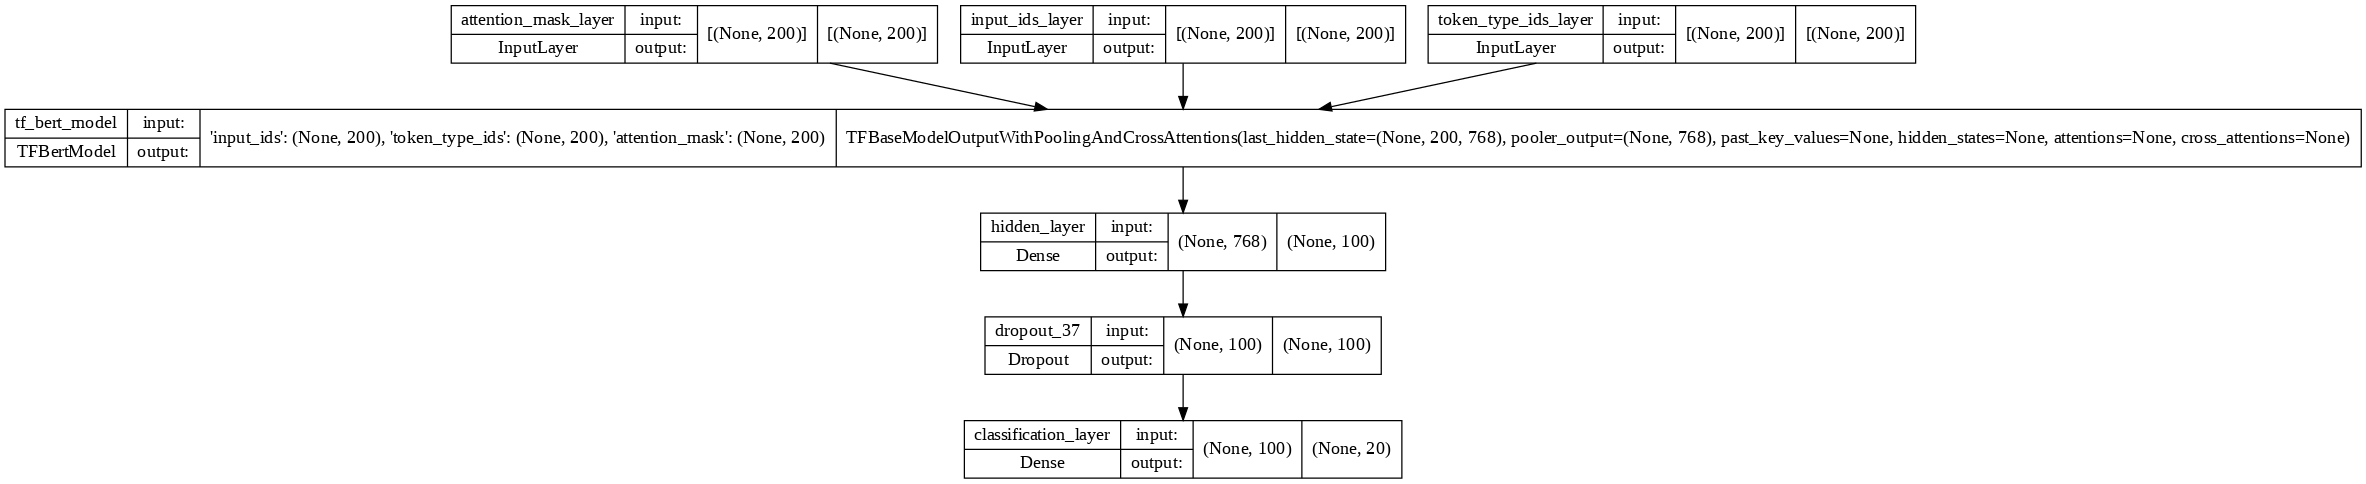

In [ ]:
keras.utils.plot_model(pooled_bert_model, show_shapes=True, dpi=90)

In [ ]:
#It takes 10 to 14 minutes to complete an epoch when using a GPU
pooled_bert_model_history = pooled_bert_model.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask], 
                                                  train_labels,   
                                                  validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask], 
                                                  npvalid_labels),    
                                                  batch_size=16, 
                                                  epochs=1)  

1000/1000 [==============================] - 177s 173ms/step - loss: 1.1190 - accuracy: 0.6603 - val_loss: 1.0006 - val_accuracy: 0.6889


Now we need to run evaluate against our fine-tuned model.  This will give us an overall accuracy based on the test set.

In [ ]:
#batch 8, ML=200
score = pooled_bert_model.evaluate([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask], 
                                                  test_labels) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

59/59 [==============================] - 16s 271ms/step - loss: 1.0008 - accuracy: 0.6987
Test loss: 1.0007688999176025
Test accuracy: 0.6986737251281738


**QUESTION:** 2.3 What is the Test accuracy score you get from your model with a batch size of 8? (Just copy and paste the value into the answers sheet and round to five significant digits.)

0.66525

In [ ]:
#run predict for the first three elements in the test data set
predictions = pooled_bert_model.predict([test_encodings.input_ids[:3], test_encodings.token_type_ids[:3], test_encodings.attention_mask[:3]])

In [ ]:
predictions

array([[1.10212311e-01, 6.99459400e-04, 2.65700131e-04, 5.79164771e-04,
        2.15017004e-03, 7.04485283e-04, 1.02246890e-03, 4.39086836e-03,
        1.58867042e-03, 5.93486195e-03, 1.32757484e-03, 1.45440118e-03,
        1.35364919e-03, 3.18511645e-03, 1.35701953e-03, 6.16731524e-01,
        7.88811222e-03, 1.13730156e-03, 3.58536164e-03, 2.34431729e-01],
       [1.27726058e-02, 6.76427960e-01, 2.02948824e-02, 4.58301865e-02,
        3.36545818e-02, 6.07834905e-02, 1.96444429e-02, 2.67432816e-03,
        8.25486705e-03, 6.24009222e-03, 6.35792362e-03, 1.39368623e-02,
        3.39759700e-02, 9.28989332e-03, 1.72808915e-02, 5.68775414e-03,
        6.37378311e-03, 8.61168373e-03, 8.18791334e-03, 3.71994940e-03],
       [1.69621233e-03, 5.98985590e-02, 1.00891955e-01, 4.96021062e-01,
        2.41878927e-01, 2.99853738e-02, 7.55744055e-03, 4.77863150e-03,
        1.22589723e-03, 7.53844040e-04, 2.71592027e-04, 3.03355907e-03,
        4.25207019e-02, 4.44132462e-03, 1.96031714e-03, 1.0146

In [ ]:
#run and capture all predictions from our test set using model.predict
### YOUR CODE HERE
predictions = pooled_bert_model.predict([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask])

### END YOUR CODE

#now we need to get the highest probability in the distribution for each prediction
#and store that in a tf.Tensor
predictions = tf.argmax(predictions, axis=-1)
predictions

<tf.Tensor: shape=(1885,), dtype=int64, numpy=array([15,  1,  4, ...,  5, 15, 16])>

There are two ways to see what's going on with our classifier.  Overall accuracy is interesting but it can be misleading.  We need to make sure that each of our categories' prediction performance is operating at an equal or higher level than the overall.

Here we'll use the classification report from scikit learn.  It expects two inputs as arrays.  One is the ground truth (y_true) and the other is the associated prediction (y_pred).  This is based on gethering all the predictions from our our test set.

In [ ]:
print(classification_report(test_labels, predictions.numpy(), target_names=target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.55      0.52      0.53        88
           comp.graphics       0.61      0.58      0.59       100
 comp.os.ms-windows.misc       0.62      0.66      0.64       104
comp.sys.ibm.pc.hardware       0.60      0.60      0.60        97
   comp.sys.mac.hardware       0.63      0.78      0.69        98
          comp.windows.x       0.80      0.82      0.81        95
            misc.forsale       0.87      0.75      0.81       105
               rec.autos       0.47      0.71      0.57        97
         rec.motorcycles       0.68      0.77      0.72       107
      rec.sport.baseball       0.89      0.78      0.83        90
        rec.sport.hockey       0.85      0.90      0.87        99
               sci.crypt       0.82      0.76      0.79        96
         sci.electronics       0.72      0.46      0.56        95
                 sci.med       0.82      0.84      0.83        79
         

**QUESTION:** 2.4 What is the macro average f1 score you get from the classification report for batch size 8?  

0.65

Now we'll generate another very valuable visualization of what's happening with our classifier -- a confusion matrix.

In [ ]:
cm = tf.math.confusion_matrix(test_labels, predictions)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

And now we'll display it!

Text(159.0, 0.5, 'True')

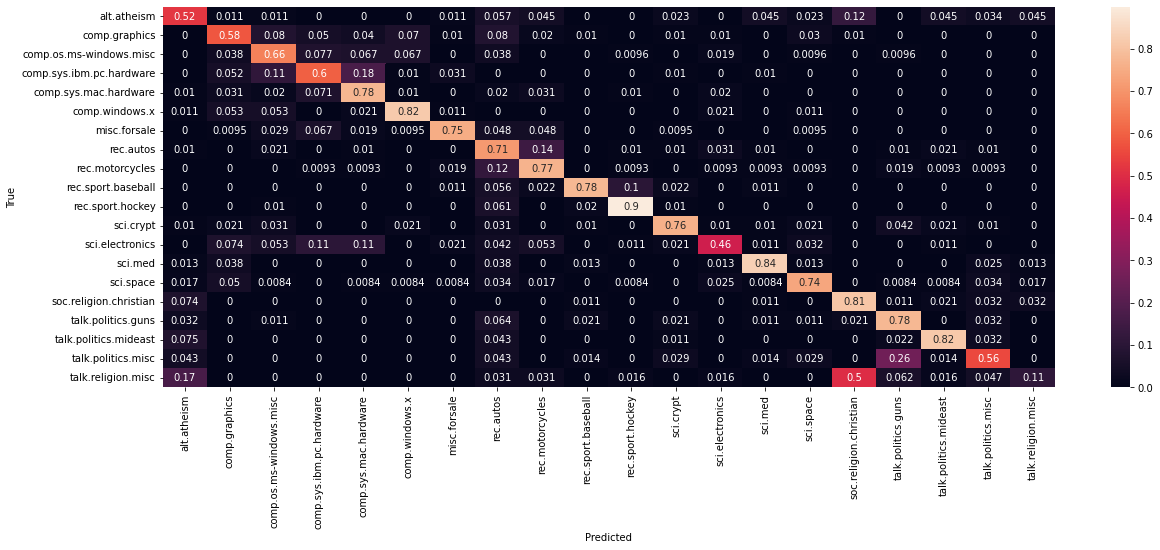

In [ ]:
plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=target_names,
    yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")


### 3. Classification with some preprocessed data and the BERT model

Okay, not bad.  As you saw there are a lot of odd characters in our input so maybe cleaning some of those out and forcing everything to lower case while running a bert-base-uncased model will give us some imporvement in our prediciotns.  Let's give that a shot.  First let's clean out our text a bit.  Remember, it is critical that we preform identical preprocessing on our training, text, and validation sets.

In [ ]:
import re
def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence = sentence.replace('\n', ' ')
    #what other characters or strings might you replace to clean up this data
    #we don't expect a full set.  Please enter six of them here.
    ### YOUR CODE HERE
    # remove anything non letter and replace with space
    sentence = re.sub(r'[^A-Za-z]', ' ', sentence)
    # remove all multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    # remove tabs
    sentence = sentence.replace('\t', ' ')
    ### END YOUR CODE
    return sentence

cleantrain_texts = list(map(preprocess, train_texts))

#you need to make sure you apply the same preprocessing to the test and validation sets
### YOUR CODE HERE
cleantest_texts = list(map(preprocess, test_texts))
cleanvalid_texts = list(map(preprocess, valid_texts))

### END YOUR CODE

In [ ]:
train_texts[:2]

[": Detroit's going to beat Toronto in 6 or LESS!!!\n: \n:  Granted, Gilmour should get the Hart Trophy, NOT Lemieux... Just\n: Look at what Gilmour did for Toronto.  When you think of Toronto,\n: who comes to mind, Gilmour, Andreychuk, Potvin...ah...did I mentio\n: n Gilmour?\n: \n\nWhen you think of the NHL, who comes to mind? Gilmour? Gretzky? Mario?\n.. ah... did I mention Mario? If you said Gretzky, you haven't really\nbeen following along, have you. If you said Gilmour, you are a true\nMaynard. \n\nI don't even think the selection of the HArt deserves serious discussion on\nthis group. It is a no-brainer.",
 'For Sale:\n\nFujitsu 324meg SCSI drive.  $450\n\nMaxtor 338meg ESDI drive.  $425\n\nMaxtor 160meg ESDI drive.  $225\n\nToshiba 106meg IDE drive.  $175\n\nXT case & motherboard.  $50\n\nDTC 16-bit MFM 2HD 2FD controler.  $30\n\nAll items are used, in full working condition, and have a  \nwarranty for one week unless otherwise specified.  All prices \nare %100 negotiable, ship

In [ ]:
cleantrain_texts[:2]

[' detroit s going to beat toronto in or less granted gilmour should get the hart trophy not lemieux just look at what gilmour did for toronto when you think of toronto who comes to mind gilmour andreychuk potvin ah did i mentio n gilmour when you think of the nhl who comes to mind gilmour gretzky mario ah did i mention mario if you said gretzky you haven t really been following along have you if you said gilmour you are a true maynard i don t even think the selection of the hart deserves serious discussion on this group it is a no brainer ',
 'for sale fujitsu meg scsi drive maxtor meg esdi drive maxtor meg esdi drive toshiba meg ide drive xt case motherboard dtc bit mfm hd fd controler all items are used in full working condition and have a warranty for one week unless otherwise specified all prices are negotiable shipping not included wanted developers kit for sb svga moniters two of them ']

In [ ]:
cleantest_texts[:2]

[' i m sort of mystified about how a christian might respond to this i ll start with a parable a christian woman hires a carpenter to build her a birdhouse when he comes over they begin talking about religion so you believe that you understand god he asks yes i do she replies then have him build you the birdhouse ',
 'sigkids call for participation sigkids research showcase is where learning is hip pushing the edge in education computer graphics and new technologies the sigkids research showcase will provide siggraph s attendees with the latest in applying computer technology to form state of the art educational experiences so hop to it submit any works which converge the disciplines of education and computer technology possible categories and domains include but are not limited to interactive stand alone applications self run demonstrations and tutorials museum installations groupware collaborative systems hypermedia virtual reality scientific visualization interactive art microworlds

In [ ]:
model_checkpoint = 'bert-base-uncased'
bert_uctokenizer = BertTokenizer.from_pretrained(model_checkpoint)
bert_model = TFBertModel.from_pretrained(model_checkpoint)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# tokenize the dataset, truncate when passed `max_length`, 
# and pad with 0's when less than `max_length`
cleantrain_encodings = bert_uctokenizer(cleantrain_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
cleanvalid_encodings = bert_uctokenizer(cleanvalid_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
cleantest_encodings = bert_uctokenizer(cleantest_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')

In [ ]:
cleanvalid_encodings.input_ids[:2]

<tf.Tensor: shape=(2, 200), dtype=int32, numpy=
array([[  101,  3398,  2021,  1996,  3291,  2007,  3173,  2039,  1996,
         4469, 11581,  4973,  2004,  4654,  6633, 24759, 11650,  2030,
         2004, 25416, 26117,  2015,  1997,  2092,  2631, 16134,  2003,
         2008,  2017,  2448, 21526,  2039,  2114,  2107,  4895,  8557,
         3993,  7826,  2004,  1048, 23274, 16107,  2107,  4469, 11581,
         3572,  2024, 12731,  9488, 24279,  2025, 12468,  2000, 16134,
          102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0, 

Call the function to recreate our BERT model only this time it will use the model_checkpoint of bert-base-uncased.

In [ ]:
clean_pooled_bert_model = create_bert_multiclass_model()

In [ ]:
clean_pooled_bert_model_history = clean_pooled_bert_model.fit([cleantrain_encodings.input_ids, cleantrain_encodings.token_type_ids, cleantrain_encodings.attention_mask], 
                                                  train_labels,   
                                                  validation_data=([cleanvalid_encodings.input_ids, cleanvalid_encodings.token_type_ids, cleanvalid_encodings.attention_mask],
                                                                   npvalid_labels),    
                                                  batch_size=16, 
                                                  epochs=1)

1000/1000 [==============================] - 414s 407ms/step - loss: 0.8128 - accuracy: 0.7544 - val_loss: 0.8915 - val_accuracy: 0.7451


This will only display a plot if we've run for more than one epoch.  We're not asking you to run more than one in this assignment but when you're done you might try running another just to see how much more the model learns.

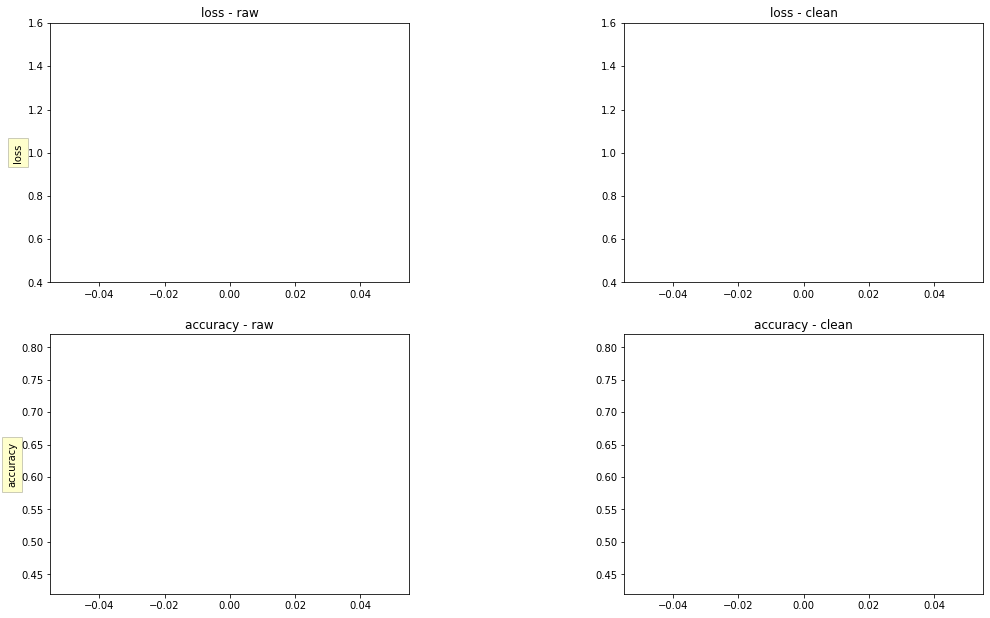

In [ ]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs, 
          pooled_bert_model_history, 
          clean_pooled_bert_model_history, 
          model_1_name='raw',
         model_2_name='clean',
         y_lim_accuracy_lower=0.42,
         y_lim_accuracy_upper=0.82)

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

In [ ]:
#Evaluate the fine tuned clean model against the cleaned test data
### YOUR CODE HERE
score = clean_pooled_bert_model.evaluate([cleantest_encodings.input_ids, cleantest_encodings.token_type_ids, cleantest_encodings.attention_mask], 
                                                  test_labels) 

### END YOUR CODE
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

59/59 [==============================] - 16s 271ms/step - loss: 0.9790 - accuracy: 0.7215
Test loss: 0.9789501428604126
Test accuracy: 0.721485435962677


**QUESTION:** 

3.1 What is the test accuracy you get when you run the cleaned model with batch size 8?

0.6785


In [ ]:
#run and capture all the predictions from the clean test data
### YOUR CODE HERE 
predictions = clean_pooled_bert_model.predict([cleantest_encodings.input_ids, cleantest_encodings.token_type_ids, cleantest_encodings.attention_mask])
predictions = tf.argmax(predictions, axis=-1)
### END YOUR CODE
predictions

<tf.Tensor: shape=(1885,), dtype=int64, numpy=array([15,  1,  1, ...,  5, 15, 18])>

In [ ]:
#Generate a confusion matrix using your new clean test predictions
### YOUR CODE HERE
ccm = tf.math.confusion_matrix(test_labels, predictions)
ccm = ccm/ccm.numpy().sum(axis=1)[:, tf.newaxis]
### END YOUR CODE

Text(159.0, 0.5, 'True')

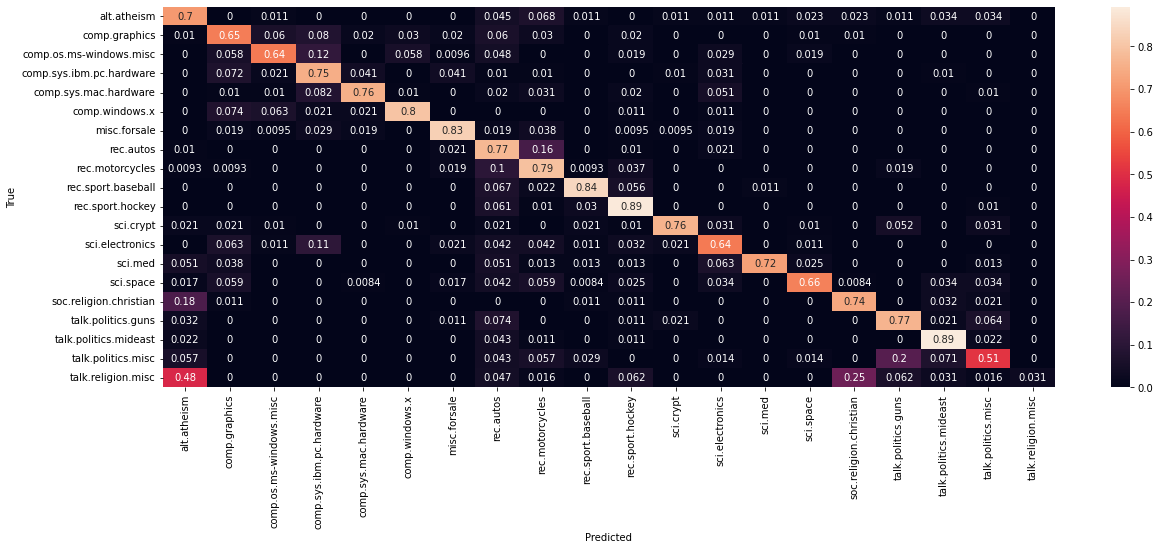

In [ ]:
#display that new confusion matrix
plt.figure(figsize=(20,7))
sns.heatmap(
    ccm, annot=True,
    xticklabels=target_names,
    yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")

In [ ]:
# Run the sklearn classification_report again with the new predictions
### YOUR CODE HERE
print(classification_report(test_labels, predictions.numpy(), target_names=target_names))
### END YOUR CODE

                          precision    recall  f1-score   support

             alt.atheism       0.48      0.70      0.57        88
           comp.graphics       0.60      0.65      0.62       100
 comp.os.ms-windows.misc       0.78      0.64      0.71       104
comp.sys.ibm.pc.hardware       0.63      0.75      0.69        97
   comp.sys.mac.hardware       0.87      0.76      0.81        98
          comp.windows.x       0.87      0.80      0.84        95
            misc.forsale       0.84      0.83      0.84       105
               rec.autos       0.50      0.77      0.61        97
         rec.motorcycles       0.61      0.79      0.69       107
      rec.sport.baseball       0.85      0.84      0.85        90
        rec.sport.hockey       0.73      0.89      0.80        99
               sci.crypt       0.91      0.76      0.83        96
         sci.electronics       0.67      0.64      0.66        95
                 sci.med       0.97      0.72      0.83        79
         

**QUESTION:**

3.2 What is the weighted avg F1 score in the classification when you run the cleaned model with batch size of 8?

0.67

### 4. Try again with a different mini batch size to see if that improves performance

Now go back and rerun both the regular and the clean data models but change the batchsize to 16 instead of 8.

** You do NOT need to rebuild the data. You just need to rerun the BERT models and the metrics for the new batch size **

What do you notice?  Does the accuracy go up or down?

**QUESTION:**

4.1 What is the Test accuracy you get when you run the cleaned model with batch size 16? (copy and paste the value rounding to five significant digits)

0.72149

4.2 Which category is consistenly underperforming in both the classification reports and the confusion matrices?

talk.religion.misc

Count up the train labels to see how many records there are for each of the 20 categories.  We've assumed they're evenly distributed. 

In [ ]:
#count_dict = ...
### YOUR CODE HERE
from collections import Counter
count_dict = Counter(train_labels)
### END YOUR CODE
pprint(count_dict, compact=True)

Counter({13: 869,
         15: 852,
         10: 848,
         5: 846,
         9: 845,
         11: 842,
         7: 841,
         12: 836,
         2: 833,
         8: 833,
         3: 832,
         4: 829,
         6: 825,
         14: 825,
         1: 811,
         17: 797,
         16: 767,
         0: 675,
         18: 662,
         19: 532})


**QUESTION:** 

4.3 The training data set is evenly distributed across all of the categories (True or False)?  
False

Is there a possible relation between those counts and what we've seen in the confusion matrices? 
Yes, it appears some of the worst performing classifications, based on the confusion matrix, are those categories with the fewest training examples.